<a href="https://colab.research.google.com/github/ML-HW-SYS/a2-kpan02/blob/main/6_pruning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **6. Model Pruning**

## 6.0 Setup GDrive and Git

In [1]:
# Mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# Make sure your token is stored in a txt file at the location below.
# This way there is no risk that you will push it to your repo
# Never share your token with anyone, it is basically your github password!
with open('/content/gdrive/MyDrive/ece5545/token.txt') as f:
    token = f.readline().strip()
# Use another file to store your github username
with open('/content/gdrive/MyDrive/ece5545/git_username.txt') as f:
    handle = f.readline().strip()

In [3]:
# Clone your github repo
YOUR_TOKEN = token
YOUR_HANDLE = handle
BRANCH = "main"

%mkdir /content/gdrive/MyDrive/ece5545
%cd /content/gdrive/MyDrive/ece5545
!git clone https://{YOUR_TOKEN}@github.com/ML-HW-SYS/a2-{YOUR_HANDLE}.git
%cd /content/gdrive/MyDrive/ece5545/a2-{YOUR_HANDLE}
!git checkout {BRANCH}
!git pull
%cd /content/gdrive/MyDrive/ece5545

PROJECT_ROOT = f"/content/gdrive/MyDrive/ece5545/a2-{YOUR_HANDLE}"

mkdir: cannot create directory ‘/content/gdrive/MyDrive/ece5545’: File exists
/content/gdrive/MyDrive/ece5545
fatal: destination path 'a2-kpan02' already exists and is not an empty directory.
/content/gdrive/MyDrive/ece5545/a2-kpan02
Already on 'main'
Your branch is up to date with 'origin/main'.
Already up to date.
/content/gdrive/MyDrive/ece5545


In [4]:
# This extension reloads all imports before running each cell
%load_ext autoreload
%autoreload 2

### GPU: Ensure you are running the GPU runtime type:
1.   Click "Runtime" on top banner
2.   Select "Change runtime type"
3.   Under "Hardware accelarator" select "GPU" and save

### Install required packages

In [5]:
!pip install torchaudio

  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl (664.8 MB)
Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl (127.9 MB)
  Attempting uninstall: nvidia-cudnn-cu12
    Found existing installation: nvidia-cudnn-cu12 9.3.0.75
    Uninstalling nvidia-cudnn-cu12-9.3.0.75:
      Successfully uninstalled nvidia-cudnn-cu12-9.3.0.75
  Attempting uninstall: nvidia-cusolver-cu12
    Found existing installation: nvidia-cusolver-cu12 11.6.3.83
    Uninstalling nvidia-cusolver-cu12-11.6.3.83:
      Successfully uninstalled nvidia-cusolver-cu12-11.6.3.83


### Import code dependencies

In [6]:
# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.utils.prune as prune

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import copy

import time

import sys

# Adding assignment1 to the system path-- make sure this matches your git directory
sys.path.insert(0, PROJECT_ROOT)

# Import data_proc to use data processing functions
import src.data_proc as data_proc

# Import constants to use constants defined for training
from src.constants import *

# TensorBoard
from torch.utils.tensorboard import SummaryWriter

# Set random seed
# Make sure the shuffling and picking is deterministic
# Note that different value of random_seed may change rate of variation in loss/accuracy during training
# Using the same random seed value every time you rerun the notebook will
# reproduce the training and testing results
random_seed = 0
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)

Model folders are created, 
PyTorch models will be saved in /content/gdrive/MyDrive/ece5545/models/torch_models, 
ONNX models will be saved in /content/gdrive/MyDrive/ece5545/models/onnx_models, 
TensorFlow Saved Models will be saved in /content/gdrive/MyDrive/ece5545/models/tf_models, 
TensorFlow Lite models will be saved in /content/gdrive/MyDrive/ece5545/models/tflite_models, 
TensorFlow Lite Micro models will be saved in /content/gdrive/MyDrive/ece5545/models/micro_models.


## 6.1 Prepare for Training



In [7]:
# Create audio_processor
# DATASET_DIR is defined in constants.py
audio_processor = data_proc.AudioProcessor()
print("Audio_processor created")

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using {device} to run the training scrpit.')

# Define data loaders
from src.loaders import make_data_loaders
data_loaders = make_data_loaders(audio_processor, device)
train_loader = data_loaders['training']
test_loader = data_loaders['testing']
valid_loader = data_loaders['validation']

# Create a full precision (float32) TinyConv model
from src.networks import TinyConv
model_fp32 = TinyConv(model_settings=audio_processor.model_settings, \
    n_input=1, n_output=audio_processor.num_labels)

model_fp32

>> Downloading speech_commands_v0.02.tar.gz 100.0%
Audio_processor created
Using cuda to run the training scrpit.
Train size: 10556 Val size: 1333 Test size: 1368


TinyConv(
  (conv_reshape): Reshape(output_shape=(-1, 1, 49, 40))
  (conv): Conv2d(1, 8, kernel_size=(10, 8), stride=(2, 2), padding=(5, 3))
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_reshape): Reshape(output_shape=(-1, 4000))
  (fc): Linear(in_features=4000, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)

In [8]:
!ls {TORCH_DIR}

 fp32_checkpoint.pt	      '(QAT4bit)quant_0.pt'   tinyconv_float32_init_seed0_90.28%_0.pt
 fp32_finetune_checkpoint.pt   quant_checkpoint.pt


### **TODO: Replace the torch_path model with the model you created in the last section.**

You can find the name of your file in `TORCH_DIR` under the folder icon to the left. (Or from running the tab above).

In [9]:
# TODO: Replace me!
torch_path = os.path.join(TORCH_DIR, "tinyconv_float32_init_seed0_90.28%_0.pt")

# Load model
model_fp32.load_state_dict(torch.load(torch_path))
model_fp32_orig = copy.deepcopy(model_fp32)
model_fp32, model_fp32_orig

(TinyConv(
   (conv_reshape): Reshape(output_shape=(-1, 1, 49, 40))
   (conv): Conv2d(1, 8, kernel_size=(10, 8), stride=(2, 2), padding=(5, 3))
   (relu): ReLU()
   (dropout): Dropout(p=0.5, inplace=False)
   (fc_reshape): Reshape(output_shape=(-1, 4000))
   (fc): Linear(in_features=4000, out_features=4, bias=True)
   (softmax): Softmax(dim=1)
 ),
 TinyConv(
   (conv_reshape): Reshape(output_shape=(-1, 1, 49, 40))
   (conv): Conv2d(1, 8, kernel_size=(10, 8), stride=(2, 2), padding=(5, 3))
   (relu): ReLU()
   (dropout): Dropout(p=0.5, inplace=False)
   (fc_reshape): Reshape(output_shape=(-1, 4000))
   (fc): Linear(in_features=4000, out_features=4, bias=True)
   (softmax): Softmax(dim=1)
 ))

## 6.3 Unstructured Pruning

In this section, you will perform unstructured pruning on the TinyConv model and explore its effect on performance.

Following link will be helpful:
1. [torch.nn.utils.prune.l1_unstructured](https://pytorch.org/docs/stable/generated/torch.nn.utils.prune.l1_unstructured.html?highlight=unstructured#torch.nn.utils.prune.l1_unstructured)

2. [torch.nn.utils.prune.random_unstructured](https://pytorch.org/docs/stable/generated/torch.nn.utils.prune.random_unstructured.html?highlight=unstructured#torch.nn.utils.prune.random_unstructured)

2. [Torch pruning tutorial](https://pytorch.org/tutorials/intermediate/pruning_tutorial.html?highlight=prune)

Define Pruning Thresholds and Helper Functions

In [10]:
pruning_thresholds = [0.2, 0.4, 0.6, 0.8, 0.9]  # 20%, 40%, 60%, 80%, 90%

# Helper function to calculate model sparsity
def calculate_sparsity(model):
    total_params = 0
    zero_params = 0

    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            if hasattr(module, 'weight'):
                total_params += module.weight.nelement()
                zero_params += torch.sum(module.weight == 0).item()

    sparsity = 100.0 * zero_params / total_params if total_params > 0 else 0
    return sparsity, zero_params, total_params

# Helper function to count non-zero parameters
def count_parameters(model):
    total_params = 0
    nonzero_params = 0

    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            if hasattr(module, 'weight'):
                total_params += module.weight.nelement()
                nonzero_params += torch.sum(module.weight != 0).item()

    return nonzero_params, total_params

Unstructured Pruning Functions

In [17]:
def apply_unstructured_pruning(model, amount, prune_method=prune.l1_unstructured):
    """Apply unstructured pruning to all Conv2d and Linear layers in the model"""
    pruned_model = copy.deepcopy(model)

    for name, module in pruned_model.named_modules():
        if isinstance(module, nn.Conv2d):
            prune_method(module, name='weight', amount=amount)
        elif isinstance(module, nn.Linear):
            prune_method(module, name='weight', amount=amount)

    return pruned_model

# Function to make pruning permanent (remove reparameterization)
def make_pruning_permanent(model):
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            if hasattr(module, 'weight_orig'):
                prune.remove(module, 'weight')

Evaluation Function

In [15]:
def evaluate_pruned_model(model, data_loader, device):
    model.eval()
    model = model.to(torch.float32)
    model.to(device)

    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in data_loader:
            data = data.to(torch.float32).to(device)
            target = target.to(torch.long).to(device)
            output = model(data)

            # Get the predicted class
            _, predicted = torch.max(output.data, 1)

            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = 100.0 * correct / total
    return accuracy

Fine-tuning

In [16]:
def finetune_model(model, data_loaders, device, epochs=5, learning_rate=0.0001):
    model = model.to(torch.float32)
    model.to(device)
    model.train()

    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0001)
    criterion = nn.CrossEntropyLoss()

    history = {
        'train_loss': [],
        'val_accuracy': []
    }

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for inputs, targets in tqdm(data_loaders['training'], desc=f'Epoch {epoch+1}/{epochs}'):
            inputs = inputs.to(torch.float32).to(device)
            targets = targets.to(torch.long).to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(data_loaders['training'])
        history['train_loss'].append(avg_train_loss)

        # Validation phase
        val_accuracy = evaluate_pruned_model(model, data_loaders['validation'], device)
        history['val_accuracy'].append(val_accuracy)

        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_train_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    return model, history

Run Unstructured Pruning

In [18]:
results_without_finetuning = {
    'thresholds': pruning_thresholds,
    'accuracy': [],
    'parameters': []
}

results_with_finetuning = {
    'thresholds': pruning_thresholds,
    'accuracy': [],
    'parameters': []
}

original_accuracy = evaluate_pruned_model(model_fp32, test_loader, device)
original_params, total_params = count_parameters(model_fp32)
print(f"Original model - Accuracy: {original_accuracy:.2f}%, Parameters: {original_params}/{total_params}")

for threshold in pruning_thresholds:
    print(f"\n--- Pruning threshold: {threshold*100:.1f}% ---")

    pruned_model = apply_unstructured_pruning(model_fp32, amount=threshold)

    accuracy_before = evaluate_pruned_model(pruned_model, test_loader, device)
    params_before, _ = count_parameters(pruned_model)

    print(f"Before fine-tuning - Accuracy: {accuracy_before:.2f}%, Parameters: {params_before}/{total_params}")

    results_without_finetuning['accuracy'].append(accuracy_before)
    results_without_finetuning['parameters'].append(params_before)

    # Fine-tune the pruned model
    finetuned_model, _ = finetune_model(
        copy.deepcopy(pruned_model),
        data_loaders,
        device,
        epochs=5,
        learning_rate=0.0001
    )


    accuracy_after = evaluate_pruned_model(finetuned_model, test_loader, device)
    params_after, _ = count_parameters(finetuned_model)

    print(f"After fine-tuning - Accuracy: {accuracy_after:.2f}%, Parameters: {params_after}/{total_params}")
    results_with_finetuning['accuracy'].append(accuracy_after)
    results_with_finetuning['parameters'].append(params_after)

Original model - Accuracy: 88.52%, Parameters: 16640/16640

--- Pruning threshold: 20.0% ---
Before fine-tuning - Accuracy: 88.23%, Parameters: 13312/16640


Epoch 1/5:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch 1/5, Loss: 0.3202, Val Accuracy: 91.07%


Epoch 2/5:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch 2/5, Loss: 0.3131, Val Accuracy: 91.37%


Epoch 3/5:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch 3/5, Loss: 0.3061, Val Accuracy: 91.82%


Epoch 4/5:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch 4/5, Loss: 0.2987, Val Accuracy: 91.15%


Epoch 5/5:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch 5/5, Loss: 0.3006, Val Accuracy: 90.55%
After fine-tuning - Accuracy: 90.94%, Parameters: 13312/16640

--- Pruning threshold: 40.0% ---
Before fine-tuning - Accuracy: 88.96%, Parameters: 9984/16640


Epoch 1/5:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch 1/5, Loss: 0.3409, Val Accuracy: 91.22%


Epoch 2/5:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch 2/5, Loss: 0.3299, Val Accuracy: 91.75%


Epoch 3/5:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch 3/5, Loss: 0.3129, Val Accuracy: 92.05%


Epoch 4/5:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch 4/5, Loss: 0.3068, Val Accuracy: 91.07%


Epoch 5/5:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch 5/5, Loss: 0.3162, Val Accuracy: 92.12%
After fine-tuning - Accuracy: 91.37%, Parameters: 9984/16640

--- Pruning threshold: 60.0% ---
Before fine-tuning - Accuracy: 63.52%, Parameters: 6656/16640


Epoch 1/5:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch 1/5, Loss: 0.7915, Val Accuracy: 88.82%


Epoch 2/5:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch 2/5, Loss: 0.4249, Val Accuracy: 89.80%


Epoch 3/5:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch 3/5, Loss: 0.3919, Val Accuracy: 89.35%


Epoch 4/5:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch 4/5, Loss: 0.3800, Val Accuracy: 89.50%


Epoch 5/5:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch 5/5, Loss: 0.3740, Val Accuracy: 90.02%
After fine-tuning - Accuracy: 89.47%, Parameters: 6656/16640

--- Pruning threshold: 80.0% ---
Before fine-tuning - Accuracy: 32.16%, Parameters: 3328/16640


Epoch 1/5:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch 1/5, Loss: 3.3261, Val Accuracy: 54.99%


Epoch 2/5:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch 2/5, Loss: 1.7255, Val Accuracy: 65.72%


Epoch 3/5:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch 3/5, Loss: 1.3360, Val Accuracy: 69.39%


Epoch 4/5:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch 4/5, Loss: 1.1661, Val Accuracy: 71.79%


Epoch 5/5:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch 5/5, Loss: 1.0287, Val Accuracy: 72.99%
After fine-tuning - Accuracy: 71.78%, Parameters: 3328/16640

--- Pruning threshold: 90.0% ---
Before fine-tuning - Accuracy: 31.21%, Parameters: 1664/16640


Epoch 1/5:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch 1/5, Loss: 6.6333, Val Accuracy: 32.78%


Epoch 2/5:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch 2/5, Loss: 4.6315, Val Accuracy: 35.18%


Epoch 3/5:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch 3/5, Loss: 3.2957, Val Accuracy: 37.43%


Epoch 4/5:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch 4/5, Loss: 2.3324, Val Accuracy: 37.21%


Epoch 5/5:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch 5/5, Loss: 1.8039, Val Accuracy: 46.66%
After fine-tuning - Accuracy: 43.86%, Parameters: 1664/16640


Results

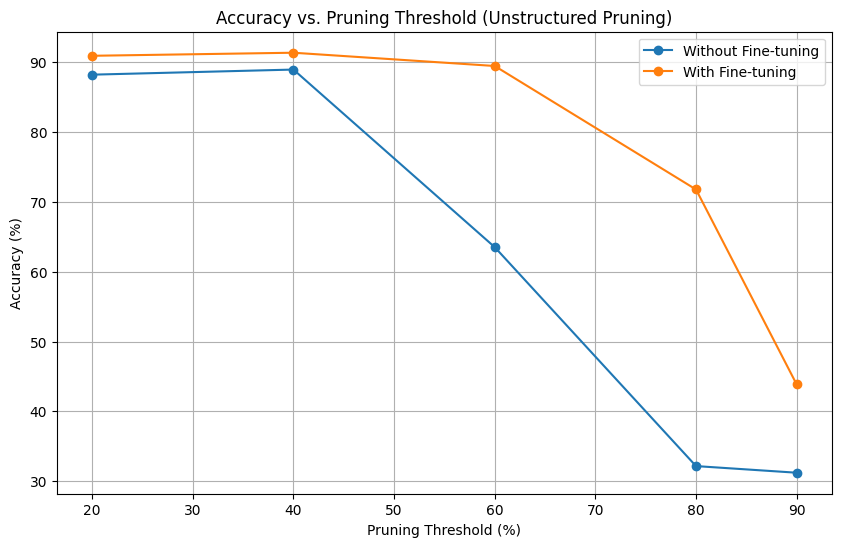

In [22]:
plt.figure(figsize=(10, 6))

plt.plot(
    [t*100 for t in results_without_finetuning['thresholds']],
    results_without_finetuning['accuracy'],
    'o-',
    label='Without Fine-tuning'
)

plt.plot(
    [t*100 for t in results_with_finetuning['thresholds']],
    results_with_finetuning['accuracy'],
    'o-',
    label='With Fine-tuning'
)

plt.xlabel('Pruning Threshold (%)')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs. Pruning Threshold (Unstructured Pruning)')
plt.legend()
plt.grid(True)
plt.show()

Analysis of different pruning norms

In [ ]:
pruning_methods = {
    'L1 Norm': prune.l1_unstructured,
    'L2 Norm': lambda module, name, amount: prune.ln_unstructured(module, name, amount, n=2),
    'Random': prune.random_unstructured
}

comparison_threshold = 0.4

norm_comparison = {
    'method': list(pruning_methods.keys()),
    'accuracy_before': [],
    'accuracy_after': []
}

for method_name, method_func in pruning_methods.items():
    print(f"\n--- Pruning method: {method_name} at {comparison_threshold*100:.1f}% ---")

    pruned_model = apply_unstructured_pruning(model_fp32, amount=comparison_threshold, prune_method=method_func)

    accuracy_before = evaluate_pruned_model(pruned_model, test_loader, device)
    print(f"Before fine-tuning - Accuracy: {accuracy_before:.2f}%")
    norm_comparison['accuracy_before'].append(accuracy_before)

    finetuned_model, _ = finetune_model(
        copy.deepcopy(pruned_model),
        data_loaders,
        device,
        epochs=5,
        learning_rate=0.0001
    )

    accuracy_after = evaluate_pruned_model(finetuned_model, test_loader, device)
    print(f"After fine-tuning - Accuracy: {accuracy_after:.2f}%")
    norm_comparison['accuracy_after'].append(accuracy_after)

## 6.2 Structured Pruning

In this section, you will try to conduct structured pruning on the TinyConv model and explore its effect on performance.
In this notebook, you will be only given minimum scarfolding code. Please take advantages of the code in previous section to faciliate.

Following link will be helpful:
[torch.nn.utils.prune.LnStructured](https://pytorch.org/docs/stable/generated/torch.nn.utils.prune.LnStructured.html?highlight=prune#torch.nn.utils.prune.LnStructured.prune)
[Torch pruning tutorial](https://pytorch.org/tutorials/intermediate/pruning_tutorial.html?highlight=prune)